# About
This data set was generated using images from the [COCO 2017 Test Images (~41k images)](http://images.cocodataset.org/zips/test2017.zip) using the method described in [HomographyNet](https://arxiv.org/pdf/1606.03798.pdf).

## Sample
A sample consists of a pair of 128x128 patches and their corresponding corner offsets (4 pairs). Note that samples are not normalized in order to save disk space (33kB for 1 unnormalized sample vs 233kB)

More specifically, a sample is a tuple of a (128, 128, 2) NumPy array (128x128 grayscale images stacked channel-wise) and a (8,) NumPy array (8-element vector containing the perturbations applied to the 4 corners).

Each image is sampled 12 times on average generating a total of 485,376 samples in total.

## Bundles
For efficient loading, samples are bundled together in NumPy archives (.npz) but are uncompressed because the compression ratio is too low to make the additional CPU time worth it. Packing is done sequentially. That is, samples from a single image are grouped together. An archive is about 96 MiB in size and contains 3,072 samples.

In this machine, a single archive can be read from disk (HDD) and loaded into memory in about 1.33s (first load, uncached). On succeeding loads (already cached), loading into memory takes about 200ms. This is much faster than having to load images individually on the fly (the HDD/CPU will bottleneck the GPU). With a batch size of 64, each archive is good for 48 iterations before having to load the next one (decreasing overall disk access and CPU wait time).

## Downloading
The files are hosted [here](http://192.168.1.126/~darwin/coco2017/). An archive's filename is also its MD5 hash, so you can easily check for file integrity.

You can easily download all the archives using wget:

`wget -rcnd -l 1 http://192.168.1.126/~darwin/coco2017/`

There are 158 archives in all, or about 15GiB of data.

In [141]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

path = '/home/darwin/Projects/datasets/packed/f01906891b1f8ea2e2715d9f99f126f6.npz'

archive = np.load(path)
print('keys:', archive.files)

images = archive['images']
offsets = archive['offsets']

print('images.shape:', images.shape)
print('offsets.shape:', offsets.shape)

sample_idx = 2335

print('sample images shape:', images[sample_idx].shape)

a=np.split(images,48)
print(a[0].shape)

keys: ['images', 'offsets']
images.shape: (3072, 128, 128, 2)
offsets.shape: (3072, 8)
sample images shape: (128, 128, 2)
(64, 128, 128, 2)


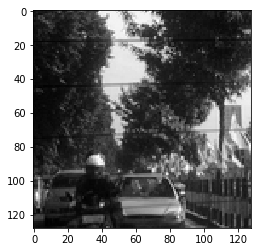

In [136]:
img = np.split(images[sample_idx], 2, axis=-1)
plt.imshow(img[0].squeeze(), cmap='gray')

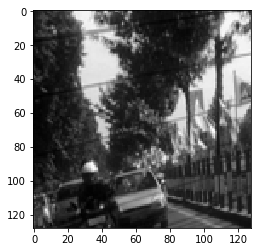

In [137]:
plt.imshow(img[1].squeeze(), cmap='gray')

In [138]:
# The order (although it doesn't matter) is: top-left, bottom-left, bottom-right, top-right
print(offsets[sample_idx])

[ 24   4  26  16  -9 -17  20  20]


In [34]:
# Efficient loading in Keras using a Python generator

import os.path
import glob

import numpy as np

def data_loader(path, batch_size=64):
    """Generator to be used with model.fit_generator()"""
    while True:
        for npz in glob.glob(os.path.join(path, '*.npz')):
            # Load pack into memory
            archive = np.load(npz)
            images = archive['images']
            offsets = archive['offsets']
            # Yield minibatch
            for i in range(0, len(offsets), batch_size):
                end_i = i + batch_size
                try:
                    batch_images = images[i:end_i]
                    batch_offsets = offsets[i:end_i]
                except IndexError:
                    continue
                # Normalize
                batch_images = (batch_images - 127.5) / 127.5
                batch_offsets = batch_offsets / 32.
                yield batch_images, batch_offsets

# Dataset-specific
train_data_path = '/path/to/training-data'
test_data_path = '/path/to/test-data'
num_samples = 150 * 3072 # 158 archives x 3,072 samples per archive, but use just 150 and save the 8 for testing

# From the paper
batch_size = 64
total_iterations = 90000

steps_per_epoch = num_samples / batch_size # As stated in Keras docs
epochs = int(total_iterations / steps_per_epoch)

# model is some Keras Model instance

# Train
model.fit_generator(data_loader(train_data_path, batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs)

# Test
model.evaluate_generator(data_loader(test_data_path, 1),
                         steps=100)